# Part 2: Simple Text Processing - Tokenization, Lemmatization, Word Frequency, Vectorization (20 pts)

Instruction:  
Please also make sure to structure your notebooks as if you were conducting this as a clean and nicely presented data analysis report. Do not include our prompts/problem statements in the final report notebooks.

## 2.1 Processing Speeches with SpaCy

In [88]:
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
from tqdm import tqdm
import numpy as np
from collections import Counter

In [47]:
nlp = spacy.load("en_core_web_sm")

sou = pd.read_csv("data/SOTU.csv")
sou["Year"] = sou["Year"].astype(int)
sou_2000 = sou[sou["Year"] >= 2000]

# Process speeches
processed_speeches = []
for text in tqdm(sou_2000["Text"], desc="Processing speeches"):
    processed_speeches.append(nlp(text))


Processing speeches: 100%|██████████| 25/25 [00:26<00:00,  1.05s/it]


## 2.2 Analyze Tokens vs Lemmas

### 2.2.1 Token List

In [48]:
tokens = []

for doc in processed_speeches:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            tokens.append(token.text.lower())

token_counts = Counter(tokens)
token_counts.most_common(25)


[('america', 816),
 ('people', 637),
 ('american', 582),
 ('new', 530),
 ('years', 439),
 ('americans', 437),
 ('world', 425),
 ('year', 406),
 ('country', 369),
 ('jobs', 348),
 ('tonight', 344),
 ('work', 324),
 ('know', 323),
 ('let', 320),
 ('congress', 317),
 ('nation', 311),
 ('time', 301),
 ('help', 282),
 ('need', 266),
 ('tax', 255),
 ('president', 247),
 ('economy', 243),
 ('like', 241),
 ('right', 240),
 ('want', 237)]

### 2.2.2 Lemma List

In [49]:
lemmas = []

for doc in processed_speeches:
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space:
            lemmas.append(token.lemma_.lower())

lemma_counts = Counter(lemmas)
lemma_counts.most_common(25)

[('year', 845),
 ('america', 816),
 ('people', 639),
 ('american', 587),
 ('work', 557),
 ('new', 532),
 ('job', 486),
 ('country', 435),
 ('americans', 432),
 ('world', 426),
 ('know', 395),
 ('nation', 388),
 ('help', 378),
 ('need', 353),
 ('time', 351),
 ('tonight', 344),
 ('child', 332),
 ('let', 326),
 ('congress', 317),
 ('come', 301),
 ('family', 296),
 ('good', 294),
 ('right', 282),
 ('million', 274),
 ('want', 264)]

## 2.3 Common Words

### 2.3.1 Common Words per Year Function

In [50]:
def get_most_common_words(df, year, n=25):
    """
    Processes the SOTU speeches for a given year and returns 
    the top n most common non-stopword, non-punctuation lemmas.
    """

    df_year = df[df["Year"] == int(year)]
    
    year_lemmas = []
    for text in df_year["Text"]:
        doc = nlp(text)
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.is_space:
                year_lemmas.append(token.lemma_.lower())

    counts = Counter(year_lemmas)
    return counts.most_common(n)


In [51]:
get_most_common_words(sou, 2024, n=20)

[('president', 58),
 ('year', 45),
 ('america', 44),
 ('american', 34),
 ('people', 33),
 ('$', 33),
 ('member', 32),
 ('want', 29),
 ('audience', 29),
 ('know', 29),
 ('pay', 29),
 ('come', 26),
 ('home', 25),
 ('family', 24),
 ('future', 23),
 ('million', 23),
 ('like', 21),
 ('build', 21),
 ('laughter', 20),
 ('americans', 20)]

### 2.3.2 Compare 2023 to 2017

In [52]:
words_2023 = get_most_common_words(sou, 2023, n=20)
words_2017 = get_most_common_words(sou, 2017, n=20)

In [53]:
words_2023

[('year', 58),
 ('go', 56),
 ('let', 45),
 ('know', 40),
 ('people', 39),
 ('job', 38),
 ('america', 36),
 ('come', 33),
 ('law', 33),
 ('pay', 33),
 ('american', 31),
 ('$', 31),
 ('president', 30),
 ('look', 27),
 ('world', 25),
 ('folk', 24),
 ('nation', 24),
 ('audience', 23),
 ('work', 23),
 ('right', 23)]

In [54]:
words_2017

[('american', 34),
 ('america', 29),
 ('country', 26),
 ('nation', 21),
 ('great', 20),
 ('new', 19),
 ('year', 19),
 ('world', 18),
 ('job', 15),
 ('people', 15),
 ('americans', 14),
 ('united', 13),
 ('tonight', 13),
 ('states', 12),
 ('work', 12),
 ('child', 12),
 ('want', 12),
 ('time', 12),
 ('citizen', 11),
 ('right', 11)]

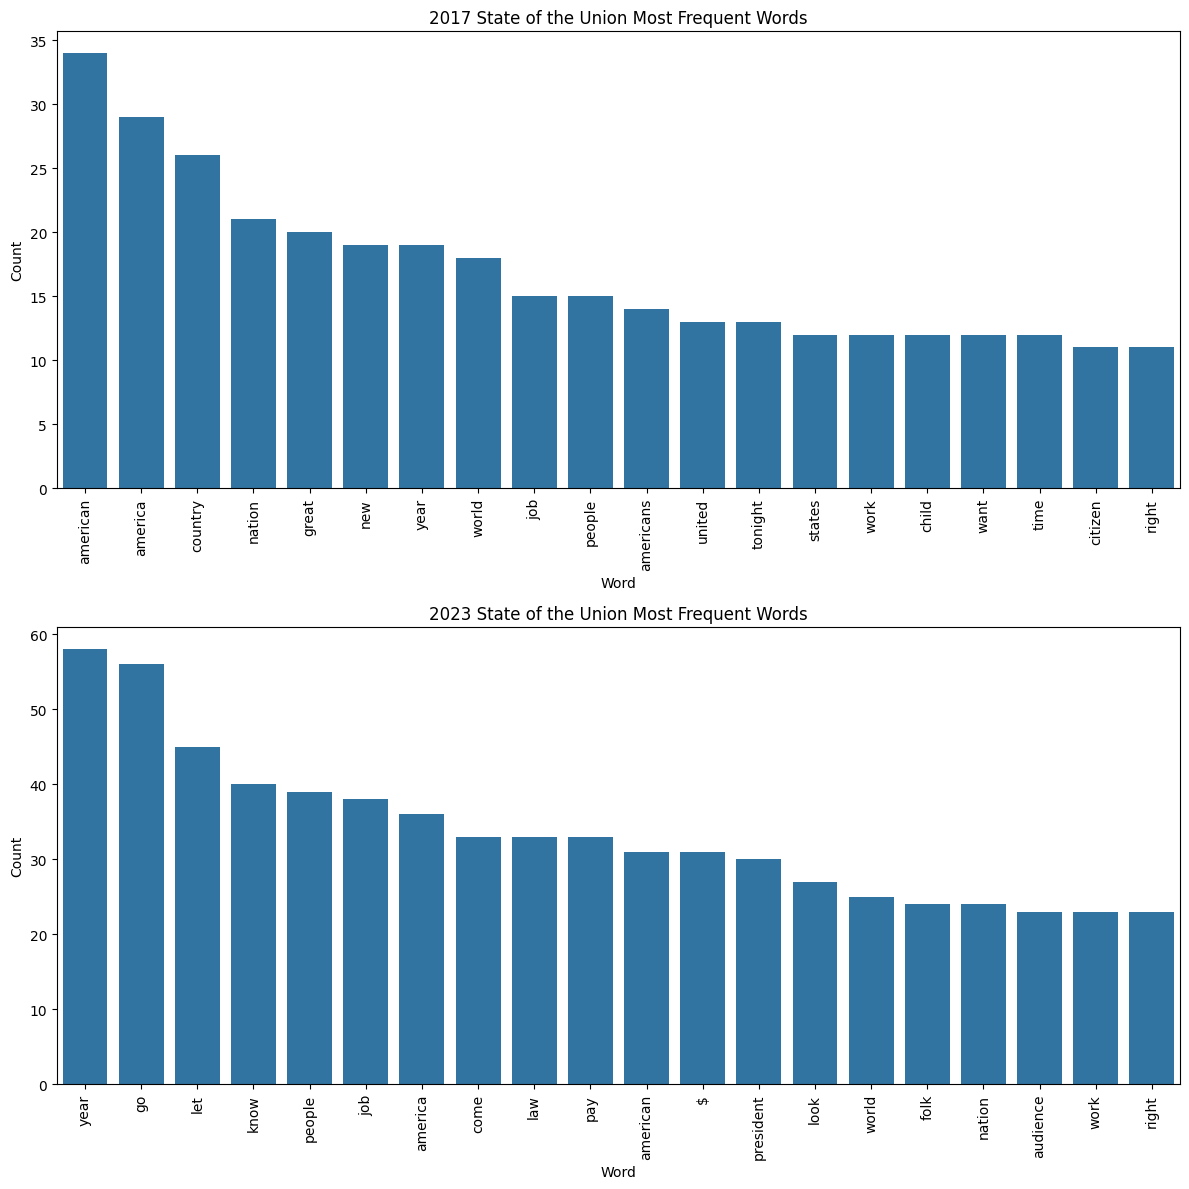

In [55]:
df_2023 = pd.DataFrame(words_2023, columns=["Word", "Count"])
df_2017 = pd.DataFrame(words_2017, columns=["Word", "Count"])

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

sns.barplot(ax=axes[0], data=df_2017, x="Word", y="Count")
axes[0].set_title("2017 State of the Union Most Frequent Words")
axes[0].tick_params(axis='x', rotation=90)

sns.barplot(ax=axes[1], data=df_2023, x="Word", y="Count")
axes[1].set_title("2023 State of the Union Most Frequent Words")
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


## 2.4 TF-IDF Vectorization

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

### 2.4.1 Train the Vectorizer and Transform the Data

In [99]:
raw_docs = sou["Text"].to_list()

In [100]:
vectorizer = TfidfVectorizer()
vectorized_docs = vectorizer.fit_transform(raw_docs)

### 2.4.2 Plot Speeches

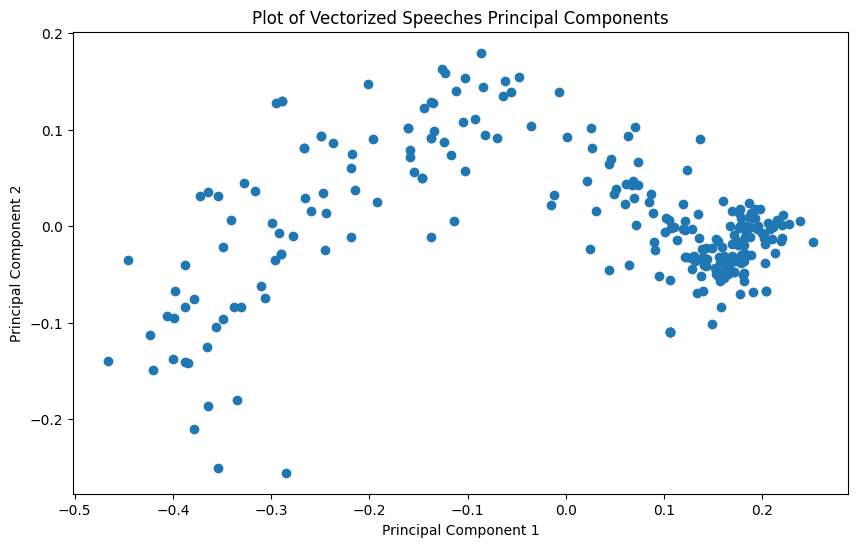

In [101]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectorized_docs.toarray())
pca_df = pd.DataFrame(data = principal_components, 
                      columns = ['Principle Component 1', 'Principle Component 2'])

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1])
plt.title("Plot of Vectorized Speeches Principal Components")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

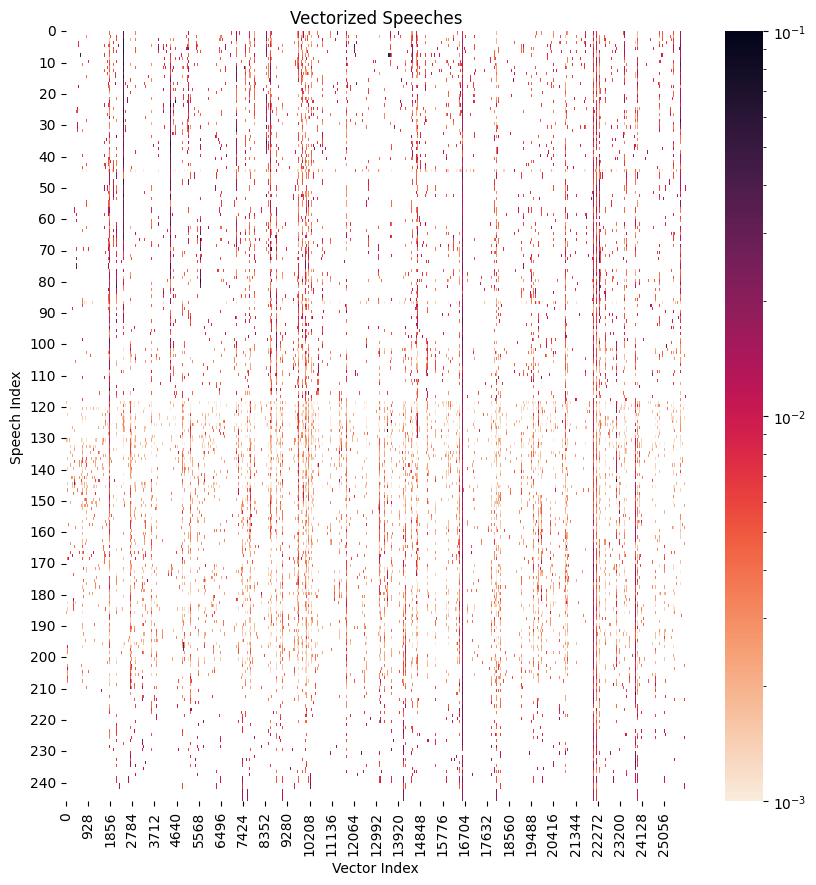

In [102]:
dense_vectorized_docs = vectorized_docs.toarray()
plt.figure(figsize=(10, 10))
sns.heatmap(
    dense_vectorized_docs,
    cmap= "rocket_r", 
    norm= LogNorm(vmin=1e-3, vmax=0.1)
)
plt.xticks(
    ticks=np.arange(0, dense_vectorized_docs.shape[1], 928),
    labels=np.arange(0, dense_vectorized_docs.shape[1], 928),
    rotation=90
)

plt.yticks(
    ticks=np.arange(0, dense_vectorized_docs.shape[0], 10),
    labels=np.arange(0, dense_vectorized_docs.shape[0], 10)
)

plt.title("Vectorized Speeches")
plt.xlabel("Vector Index")
plt.ylabel("Speech Index")
plt.show()

### 2.4.3 Get the TF-IDF value

In [104]:
word_list = ['year','america','people','american','work','new','job','country','americans','world']


In [105]:
word_nums = [vectorizer.vocabulary_.get(w, None) for w in word_list]


In [106]:
idf_score = [vectorizer.idf_[i] for i in word_nums]


In [107]:
tf_idf = [dense_matrix[0][i] for i in word_nums]


In [108]:
pd.DataFrame({"Word": word_list,
              "IDF Score": idf_score,
              "TF-IDF Score": tf_idf})


,Word,IDF Score,TF-IDF Score
0,year,1.032925,0.022719
1,america,1.272946,0.068439
2,people,1.037118,0.043087
3,american,1.102217,0.045792
4,work,1.162281,0.005681
5,new,1.024591,0.016275
6,job,2.043480,0.009988
7,country,1.008130,0.013550
8,americans,1.713598,0.041877
9,world,1.138750,0.026438
